In [78]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [79]:
cd /gdrive/My\ Drive/FakeNewsDetection

/gdrive/My Drive/FakeNewsDetection


In [0]:
import pandas as pd
import numpy as np

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [82]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [84]:
'''tsv_file='dataset/val2.tsv'
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('dataset/val.csv',index=False)'''

"tsv_file='dataset/val2.tsv'\ncsv_table=pd.read_table(tsv_file,sep='\t')\ncsv_table.to_csv('dataset/val.csv',index=False)"

In [0]:
def data_clean(df):
    clean = df.iloc[:,[2,3]]
    clean.columns = ['label','news']
    return clean

In [0]:
train = pd.read_csv('dataset/train.csv')
train = data_clean(train)
val = pd.read_csv('dataset/val.csv')
val = data_clean(val)
test = pd.read_csv('dataset/test.csv')
test = data_clean(test)

In [87]:
train.head()

,label,news
0,half-true,When did the decline of coal start? It started...
1,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
2,false,Health care reform legislation is likely to ma...
3,half-true,The economic turnaround started at the end of ...
4,true,The Chicago Bears have had more starting quart...


In [88]:
train.describe()

,label,news
count,10239,10239
unique,6,10222
top,half-true,On changing the rules for filibusters on presi...
freq,2114,3


In [89]:
train.groupby('label').describe()

news  ...     
            count  ... freq
label              ...     
barely-true  1654  ...    1
false        1994  ...    3
half-true    2114  ...    2
mostly-true  1962  ...    1
pants-fire    839  ...    1
true         1676  ...    2

[6 rows x 4 columns]

In [0]:
labels_map = {
        'true': 1,
        'mostly-true': 1,
        'half-true': 1,
        'false': 0,
        'barely-true': 0,
        'pants-fire': 0
    }
train['label'] = train['label'].map(labels_map)
test['label'] = test['label'].map(labels_map)

In [0]:
train['length'] = train['news'].apply(len)

In [92]:
train.head()

,label,news,length
0,1,When did the decline of coal start? It started...,141
1,1,"Hillary Clinton agrees with John McCain ""by vo...",105
2,0,Health care reform legislation is likely to ma...,78
3,1,The economic turnaround started at the end of ...,54
4,1,The Chicago Bears have had more starting quart...,155


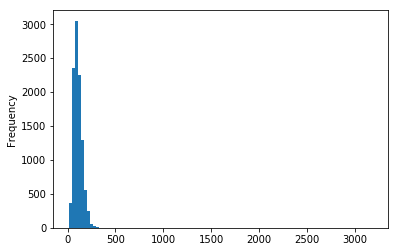

In [93]:
# Checking if length of the news is a good feature
train['length'].plot(bins = 100, kind = 'hist')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fc53eb550>,
      dtype=object)

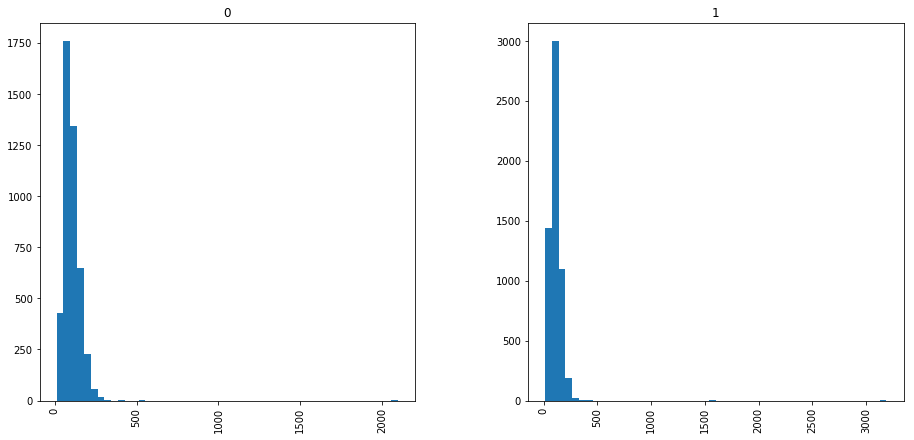

In [94]:
train.hist(column = 'length', by = 'label', bins = 50, figsize = (15,7))

In [95]:
# looks like both the labels share similar distribution of length.
train = train.drop('length', axis = 1)
train.head()

,label,news
0,1,When did the decline of coal start? It started...
1,1,"Hillary Clinton agrees with John McCain ""by vo..."
2,0,Health care reform legislation is likely to ma...
3,1,The economic turnaround started at the end of ...
4,1,The Chicago Bears have had more starting quart...


In [0]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [97]:
train['news'].head().apply(text_process)

0    [decline, coal, start, started, natural, gas, ...
1    [Hillary, Clinton, agrees, John, McCain, votin...
2    [Health, care, reform, legislation, likely, ma...
3           [economic, turnaround, started, end, term]
4    [Chicago, Bears, starting, quarterbacks, last,...
Name: news, dtype: object

In [98]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(train['news'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

14692


In [0]:
train_bow = bow_transformer.transform(train['news'])

In [100]:
print('Shape of Sparse Matrix: ', train_bow.shape)
print('Amount of Non-Zero occurences: ', train_bow.nnz)

Shape of Sparse Matrix:  (10239, 14692)
Amount of Non-Zero occurences:  109594


In [101]:
sparsity = (100.0 * train_bow.nnz / (train_bow.shape[0] * train_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07285314684459336


In [0]:
#tfidf transformer
tfidf_transformer = TfidfTransformer().fit(train_bow)

In [103]:
train_tfidf = tfidf_transformer.transform(train_bow)
print(train_tfidf.shape)

(10239, 14692)


In [0]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process, lowercase=True, ngram_range=(1, 4))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB(alpha = 3)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [129]:
pipeline.fit(train['news'],train['label'])

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f5fc86371e0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 4), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=3, class_prior=None, fit_prior=True))],
         verbose=False)

In [0]:
predictions = pipeline.predict(test['news'])

In [131]:
print(classification_report(test['label'], predictions))
print('\n')
print(confusion_matrix(test['label'], predictions))

              precision    recall  f1-score   support

           0       0.74      0.15      0.25       553
           1       0.59      0.96      0.73       713

    accuracy                           0.61      1266
   macro avg       0.67      0.55      0.49      1266
weighted avg       0.66      0.61      0.52      1266



[[ 83 470]
 [ 29 684]]
